In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sklearn.neighbors
import desc.pserv
import desc.pserv.utils as pserv_utils

In [11]:
import healpy as hp

In [4]:
import time

In [79]:
import astropy.table

In [68]:
from multiprocessing import Pool

In [161]:
from scipy.stats import binned_statistic

In [35]:
import lsst.daf.persistence
DATA_DIR_DITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-dithered/"

In [5]:
table_name = 'StarTruth'
#projectId = 0
#projectName = 'DC1 imsim undithered'
projectId = 1
projectName = 'DC1 imsim dithered'

conn = desc.pserv.DbConnection(host='nerscdb04.nersc.gov',
                               port=3306,
                               database='DESC_DC1_Level_2')

In [33]:
star_truth = conn.get_pandas_data_frame('select * from StarTruth')
tree = sklearn.neighbors.KDTree(
    np.array(((star_truth['raICRS'].values*np.pi/180.,
               star_truth['decICRS'].values*np.pi/180.))).transpose())

query = '''select id, coord_ra, coord_dec,
           base_PsfFlux_flux, base_PsfFlux_fluxSigma
           from Coadd_Object where deblend_nChild=0
           and base_ClassificationExtendedness_value=0
           and projectId=%i limit 100000''' % projectId
query_u = '''select id, coord_ra, coord_dec,
           base_PsfFlux_flux, base_PsfFlux_fluxSigma
           from Coadd_Object where deblend_nChild=0
           and base_ClassificationExtendedness_value=0
           and projectId=%i limit 100000''' % 0
tstart = time.time()
imsim_stars = conn.get_pandas_data_frame(query)
imsim_stars_u = conn.get_pandas_data_frame(query_u)
print('query time:', time.time() - tstart)
candidates = np.array(((imsim_stars['coord_ra'].values,
                        imsim_stars['coord_dec'].values))).transpose()


('query time:', 190.74739909172058)


In [ ]:
candidates_u = np.array(((imsim_stars_u['coord_ra'].values,
                        imsim_stars_u['coord_dec'].values))).transpose()

In [7]:
offset, index = tree.query(candidates, k=1)

In [ ]:
offset_u, index_u = tree.query(candidates_u, k=1)

In [19]:
x0 = star_truth['raICRS'].values[index][::50].flatten()
y0 = star_truth['decICRS'].values[index][::50].flatten()
dx = star_truth['raICRS'].values[index][::50].flatten()-imsim_stars['coord_ra'].values[::50].flatten()*180/np.pi
dy = star_truth['decICRS'].values[index][::50].flatten()-imsim_stars['coord_dec'].values[::50].flatten()*180/np.pi
print len(x0), len(y0), len(dx), len(dy)

2000 2000 2000 2000


In [25]:
print np.where(dx*3600>0.1)

(array([   9,   12,   13,   20,   22,   27,   35,   39,   44,   51,   53,
         58,   71,   74,   84,   85,   98,  103,  104,  111,  116,  128,
        132,  133,  137,  141,  153,  163,  168,  170,  178,  184,  197,
        206,  222,  223,  226,  231,  232,  237,  247,  253,  255,  257,
        258,  260,  265,  274,  281,  287,  312,  326,  335,  342,  346,
        349,  351,  356,  358,  359,  362,  371,  373,  375,  386,  388,
        389,  392,  397,  400,  404,  411,  413,  415,  422,  425,  427,
        433,  436,  442,  446,  447,  449,  451,  456,  459,  463,  470,
        475,  477,  480,  492,  495,  498,  508,  524,  527,  528,  542,
        551,  558,  565,  566,  568,  569,  572,  583,  584,  588,  605,
        606,  608,  609,  618,  626,  629,  630,  634,  635,  638,  639,
        644,  651,  652,  656,  670,  675,  677,  701,  703,  709,  727,
        737,  744,  750,  753,  754,  755,  775,  780,  787,  789,  791,
        794,  800,  802,  809,  811,  816,  818,  

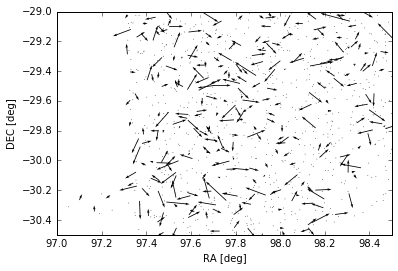

In [39]:
# We are going to multiply the arrows times 20 to be able to see them
plt.quiver(x0,y0,dx,dy, scale_units='xy', angles='xy', scale=0.05)
plt.xlim(97.0,98.5)
plt.ylim(-30.5,-29.0)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [7]:
ccd_visit = conn.get_pandas_data_frame('select * from CcdVisit')

In [8]:
ccd_visit.keys()

Index([u'ccdVisitId', u'visitId', u'ccdName', u'raftName', u'filterName',
       u'nExposures', u'ra', u'decl', u'zenithDistance', u'llcx', u'llcy',
       u'ulcx', u'ulcy', u'urcx', u'urcy', u'lrcx', u'lrcy', u'xSize',
       u'ySize', u'obsStart', u'expMidpt', u'expTime', u'darkTime', u'ccdTemp',
       u'binX', u'binY', u'WCS', u'zeroPoint', u'seeing', u'skyBg',
       u'skyNoise', u'flags', u'projectId'],
      dtype='object')

1215.98636475


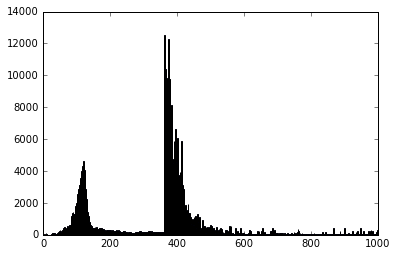

In [159]:
plt.hist(ccd_visit['skyBg'],range=(0,1000),bins=500);
print np.nanmean(ccd_visit['skyBg'][dithered_visits])

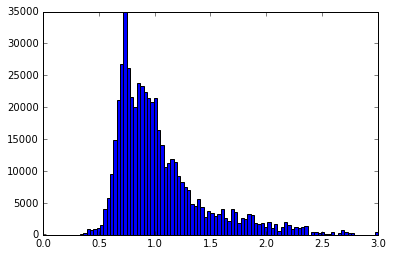

In [160]:
plt.hist(ccd_visit['seeing'],range=(0,3),bins=100);

In [39]:
ccd_visit

,ccdVisitId,visitId,ccdName,raftName,filterName,nExposures,ra,decl,zenithDistance,llcx,...,ccdTemp,binX,binY,WCS,zeroPoint,seeing,skyBg,skyNoise,flags,projectId
0,1000040336,40336,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,3.847540e+12,0.739137,136.9840,11.93500,None,2
1,1000040337,40337,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,5.321730e+12,0.712504,410.9930,20.37520,None,0
2,1000040337,40337,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,5.296920e+12,0.708314,407.8570,20.27070,None,1
3,1000040337,40337,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,3.709110e+12,0.724464,163.4410,13.08440,None,2
4,1000040338,40338,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,5.279740e+12,0.887687,404.7760,20.31500,None,0
5,1000040366,40366,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,3.253230e+12,0.721123,95.0576,9.91047,None,2
6,1000040367,40367,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,5.208530e+12,1.398960,403.9480,20.28720,None,0
7,1000040368,40368,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,5.236260e+12,1.175910,398.8000,20.18610,None,0
8,1000193157,193157,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,5.157100e+12,1.623460,1521.6700,39.08010,None,0
9,1000193157,193157,"0,0","0,1",r,None,None,None,None,None,...,None,None,None,None,2.654730e+12,0.664673,1567.7000,40.02660,None,2


In [36]:
butler = lsst.daf.persistence.Butler(DATA_DIR_DITHERED)

In [37]:
print butler.getKeys("calexp")

{'filter': <type 'str'>, 'raft': <type 'str'>, 'sensor': <type 'str'>, 'visit': <type 'int'>}


In [81]:
dithered_visits = ccd_visit['projectId'].values==1

In [70]:
def get_ra_dec(entry_num,visit_table=ccd_visit[dithered_visits],butler=butler):
    i=entry_num
    if i%1000==0:
        print i
    visitId = {'filter':visit_table['filterName'].values[i], 'raft':visit_table['raftName'].values[i],
               'sensor':visit_table['ccdName'].values[i], 'visit':visit_table['visitId'].values[i]}
    try:
        calexp = butler.get("calexp",visitId,immediate=True)
        ra=calexp.getWcs().getSkyOrigin().toIcrs().getRa().asDegrees()
        dec=calexp.getWcs().getSkyOrigin().toIcrs().getDec().asDegrees()
    except:
        ra=np.nan
        dec=np.nan
    return ra,dec

In [72]:
%time get_ra_dec(1)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.36 ms


(96.98371557635615, -30.54360903821174)

In [73]:
p = Pool(32)
p.map(get_ra_dec, [i for i in range(np.count_nonzero(dithered_visits))])

0
13000
26000
39000
3000
16000
29000
42000
6000
32000
19000
45000
9000
35000
22000
12000
25000
38000
2000
28000
15000
41000
5000
44000
18000
31000
34000
21000
8000
11000
24000
37000
1000
27000
14000
40000
17000
4000
30000
43000
7000
33000
20000
46000
10000
36000
23000
52000
65000
78000
91000
55000
68000
81000
58000
71000
84000
48000
61000
74000
87000
51000
64000
77000
90000
54000
67000
80000
57000
70000
83000
47000
60000
73000
86000
50000
63000
76000
89000
53000
66000
79000
92000
56000
69000
82000
59000
72000
85000
49000
62000
75000
88000
114000
127000
104000
117000
130000
94000
107000
120000
133000
97000
110000
123000
136000
100000
113000
126000
103000
116000
129000
93000
106000
119000
132000
96000
109000
122000
135000
99000
112000
125000
138000
102000
115000
128000
105000
118000
131000
95000
108000
121000
134000
98000
111000
124000
137000
101000
140000
153000
166000
179000
143000
156000
169000
182000
146000
159000
172000
149000
162000
175000
139000
152000
165000
178000
142000
155000


[(95.25102465703945, -30.150954320569983),
 (96.98371557635615, -30.54360903821174),
 (97.21880984326236, -30.087417232457085),
 (96.48221963024564, -29.552410163016894),
 (92.98028783509861, -31.11710129852494),
 (92.24884940748954, -30.677390449933228),
 (92.10193817196918, -31.642926563544236),
 (92.56668136153556, -26.762794054440093),
 (92.4192809561411, -27.265280300160043),
 (97.48451418784536, -29.351297808873007),
 (92.22508397676964, -26.149630651465714),
 (90.22777481114862, -26.465009449734154),
 (94.46607703404152, -26.004293946207213),
 (95.17154018855824, -27.337749320648406),
 (90.83818664890835, -28.060753841363965),
 (96.4666510434352, -28.85443476127652),
 (89.63545391466775, -28.097590808690505),
 (93.34171822705129, -28.181147814866616),
 (89.41618126948671, -27.747131928063023),
 (89.93063977774365, -25.867798205198888),
 (94.51719121533169, -29.208057511836543),
 (90.55820218189503, -26.240031869898203),
 (91.57098698444267, -26.26314033903034),
 (89.964813641098

In [74]:
ra_dec_array = np.array(_)

In [78]:
print ra_dec_array[:,0]

[ 95.25102466  96.98371558  97.21880984 ...,  95.89312305  97.24145836
  96.62448338]


In [80]:
tab = astropy.table.Table([ra_dec_array[:,0],ra_dec_array[:,1]],names=('ra [deg]', 'dec [deg]'))
tab.write('dithered_pointings_ra_dec.fits.gz')

In [173]:
def make_hp_metric(visit_table,var,metric='mean',nside=4096):
    good = np.logical_not(np.isnan(ra_dec_array[:,0]))
    pix_nums = hp.ang2pix(nside,np.pi/2.-ra_dec_array[:,1][good]*np.pi/180,ra_dec_array[:,0][good]*np.pi/180)
    pix_counts = np.bincount(pix_nums,minlength=12*nside**2)
    pix_weight = np.bincount(pix_nums,weights=visit_table[var].values[good],minlength=12*nside**2)
    pix_weight2 = np.bincount(pix_nums,weights=visit_table[var].values[good]**2,minlength=12*nside**2)
    if metric=='mean':
        map_out = np.zeros_like(pix_counts)
        map_out[pix_counts!=0] = pix_weight[pix_counts!=0]/pix_counts[pix_counts!=0]
        return map_out
    if metric=='rms':
        map_out = np.zeros_like(pix_counts)
        map_out[pix_counts!=0] = np.sqrt(pix_weight2[pix_counts!=0]/pix_counts[pix_counts!=0] \
                                         -(pix_weight[pix_counts!=0]/pix_counts[pix_counts!=0])**2)
        return map_out
    if metric=='median':
        map_out, _ , _ = binned_statistic(pix_nums,visit_table[var].values[good],bins=12*nside**2,statistic=metric,range=(0,12*nside**2))
        return map_out
    else:
        print 'Only mean and rms defined!'

In [174]:
map_seeing = make_hp_metric(ccd_visit[dithered_visits],'seeing',nside=2048)
map_seeing_rms = make_hp_metric(ccd_visit[dithered_visits],'seeing',metric='rms',nside=2048)
map_seeing_median = make_hp_metric(ccd_visit[dithered_visits],'seeing',metric='median',nside=2048)

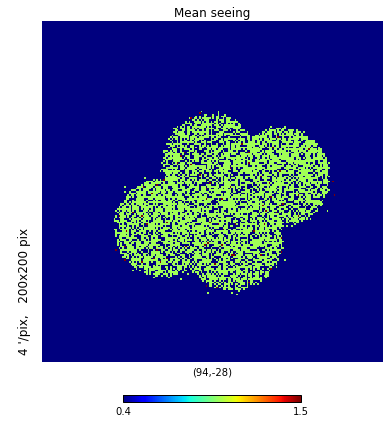

In [175]:
hp.gnomview(map_seeing, rot=(94, -28), reso=4, title='Mean seeing', max=1.5, min=0.4)

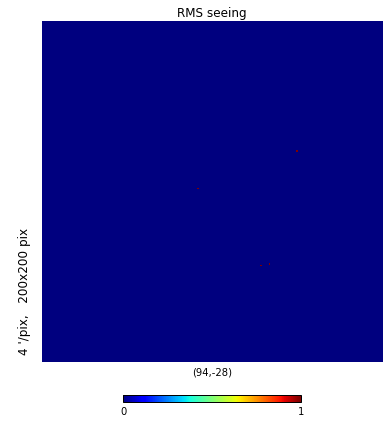

In [176]:
hp.gnomview(map_seeing_rms, rot=(94, -28), reso=4, title='RMS seeing')

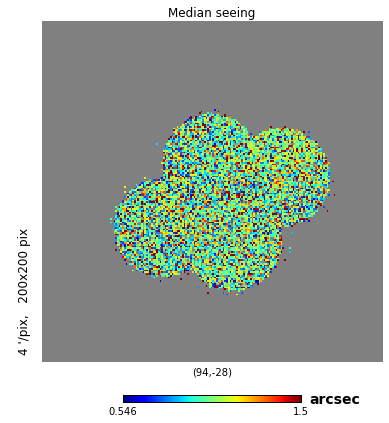

In [182]:
hp.gnomview(map_seeing_median, rot=(94, -28), reso=4, title='Median seeing', max=1.5, unit='arcsec')

In [178]:
map_bg = make_hp_metric(ccd_visit[dithered_visits],'skyBg',nside=2048)
map_bg_rms = make_hp_metric(ccd_visit[dithered_visits],'skyBg',metric='rms',nside=2048)
map_gb_median = make_hp_metric(ccd_visit[dithered_visits],'skyBg',metric='median',nside=2048)

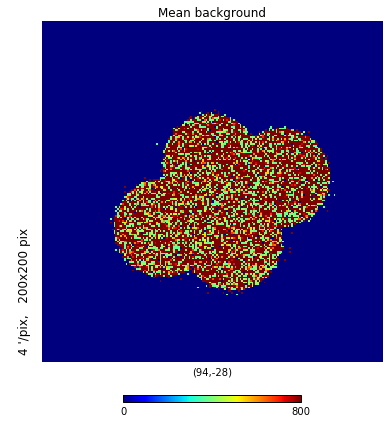

In [179]:
hp.gnomview(map_bg, rot=(94, -28), reso=4, title='Mean background',max=800, min=0)

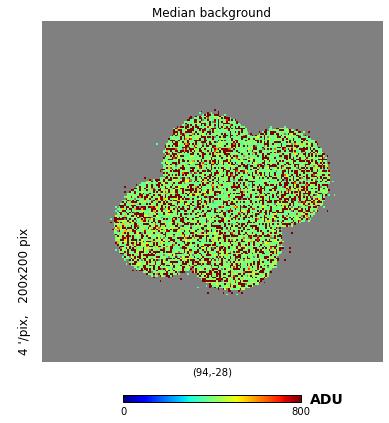

In [181]:
hp.gnomview(map_gb_median, rot=(94, -28), reso=4, title='Median background',max=800, min=0,unit='ADU')